In [1]:
from string import punctuation
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import pickle
from nltk.stem import PorterStemmer
import os
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from nrclex import NRCLex #class to find NRC lexicon emotion
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
#define function to clean news data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

#function to clean news data by removing special symbols, punctuation and stop words
def cleanNews(doc):
    tokens = doc.split()
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    tokens = [ps.stem(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = ' '.join(tokens)
    return tokens

In [3]:
#load news dataset and in this dataset Threat and No Threat label is calculated using NRC Lexicon
dataset = pd.read_csv("Dataset/News.csv")
dataset

,news_index,id,text,date_created,label
0,0,1562857443566047236,RT @StFreakingKezy: If you to confirm the auth...,2022-08-25 17:40:25+00:00,No Threat
1,1,1562856878232981517,RT @NigeriaNewsdesk: APC: North Central geo po...,2022-08-25 17:38:10+00:00,No Threat
2,2,1562856877918404608,RT @NigeriaNewsdesk: APC: North Central geo po...,2022-08-25 17:38:10+00:00,No Threat
3,3,1562856877419302913,RT @NigeriaNewsdesk: APC: North Central geo po...,2022-08-25 17:38:10+00:00,No Threat
4,4,1562856796276273153,RT @StFreakingKezy: If you to confirm the auth...,2022-08-25 17:37:51+00:00,No Threat
...,...,...,...,...,...
995,995,1560352748859785223,@Jeen_Yous Nigeria and Sierra Leone...same sto...,2022-08-18 19:47:39+00:00,Threat
996,996,1560349255356731392,RT @Cigarbell_Nna: Aunty kemi is the author of...,2022-08-18 19:33:47+00:00,No Threat
997,997,1560349233445834752,Aunty kemi is the author of fake News in Niger...,2022-08-18 19:33:41+00:00,No Threat
998,998,1560349043548737538,RT @Benn_X1: Lagos has a better economy than G...,2022-08-18 19:32:56+00:00,Threat


In [4]:
#function to label news dataset using NRC lexicon emotion
def claculateNRCLexicon(dataset):
    news = dataset['text']
    label = []
    sentiment = 0
    for i in range(len(news)):#loop all articles from news dataset
        sentiment = NRCLex(news[i]) #apply NRC lexicon
        positive_score = sentiment.affect_frequencies['positive']#get positive and negative score for threat labels
        negative_score = sentiment.affect_frequencies['negative']
        if positive_score > negative_score: #if negative score lesser than positive then no threat
            sentiment = "No Threat"
        elif negative_score > positive_score: #if neg high then its Threat
            sentiment = "Threat"
        else:
            sentiment = "No Threat" #if equal scores then news will be consider as normal or no threat
        label.append(sentiment)    
    dataset['label'] = label
    dataset.to_csv("temp.csv", index = False)#save calculated labels
    print("Calculated Lexicon Labels saved")

In [5]:
#now process dataset by extracting X and Y fetaures and removing special symbols and stop words
if os.path.exists("model/X.txt.npy"):#if dataset already process then load it
    with open('model/tfidf.txt', 'rb') as file:
        vectorizer = pickle.load(file)
    file.close()
    X = np.load("model/X.txt.npy")
    Y = np.load("model/Y.txt.npy")
else: #if not process then process dataset and saved for future loading
    calculateNRCLexicon(dataset) #function to calculate NRC lexicon emotion labels
    #now create TFIDF vector from news data
    dataset = pd.read_csv("Dataset/News.csv")
    for i in range(len(dataset)): #loop all news
        news = dataset.get_value(i, 'text') #get news text
        label = dataset.get_value(i, 'label') #get labels
        if news is not None:
            news =  news.strip().lower()
            news = cleanNews(news) #clean news data
            textdata.append(news)
            label_id = 0
            if label == "Threat":
                label_id = 1
            Y.append(label_id)        
    #create TFIDF vector from all news 
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, use_idf=True, ngram_range=(1, 1), smooth_idf=False, norm=None, decode_error='replace', max_features=768)
    tfidf = tfidf_vectorizer.fit_transform(textdata).toarray()        
    np.save("model/X.txt",tfidf)
    with open('model/tfidf.txt', 'wb') as file:
        pickle.dump(tfidf_vectorizer, file)
    file.close()
    Y = np.asarray(Y)
    np.save("model/Y.txt",Y)
print("TFIDF vector created : ")
print(X)

TFIDF vector created : 
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         5.42284863 0.        ]
 [0.         0.         0.         ... 0.         5.42284863 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


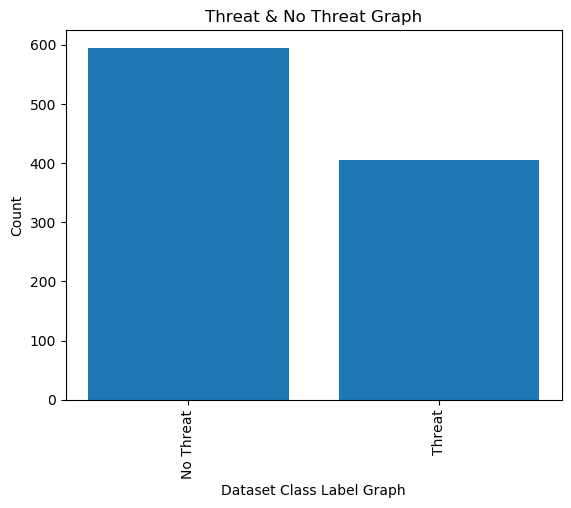

In [6]:
labels, count = np.unique(Y, return_counts=True)
labels = ['No Threat', 'Threat']
#plot graph of various class label images and its count
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.title("Threat & No Threat Graph")
plt.xticks(rotation=90)
plt.show()

In [7]:
#now preprocess dataset such as shuffling and splitting into train and test
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_test = np.load("model/X_test.npy")
y_test = np.load("model/y_test.npy")
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Total News Articles found in dataset : "+str(X.shape[0]))
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Total News Articles found in dataset : 1000
Training Size (80%): 800
Testing Size (20%): 200



In [8]:
#define global variables to calculate accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []
print("Variables Created")

Variables Created


In [9]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print()
    print(classification_report(testY, predict, target_names=labels))
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 3)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.xticks(rotation=90)
    plt.show()


              precision    recall  f1-score   support

   No Threat       0.90      0.91      0.91       116
      Threat       0.88      0.86      0.87        84

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200

Naive Bayes Accuracy  : 89.0
Naive Bayes Precision   : 88.81769326167839
Naive Bayes Recall      : 88.54679802955665
Naive Bayes FMeasure    : 88.67263927504891


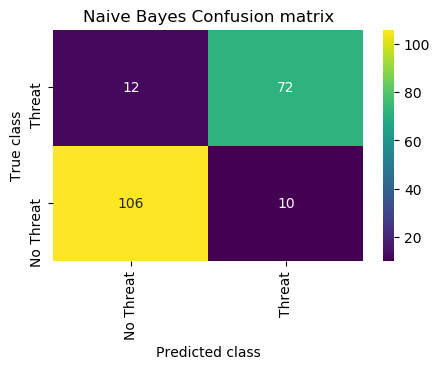

In [10]:
#now train Naive Bayes algorithm on news dataset
if os.path.exists("model/nb.txt"):
    with open('model/nb.txt', 'rb') as file:
        nb_cls = pickle.load(file)
    file.close()
else:
    nb_cls = GaussianNB()#create naive bayes object
    nb_cls.fit(X_train, y_train)#train on training data
    with open('model/nb.txt', 'wb') as file:
        pickle.dump(nb_cls, file)
    file.close()
predict = nb_cls.predict(X_test)#perform prediction on test data
#call metric function to calculate accuracy and other metrics
calculateMetrics("Naive Bayes", predict, y_test)


              precision    recall  f1-score   support

   No Threat       0.89      0.94      0.91       116
      Threat       0.91      0.83      0.87        84

    accuracy                           0.90       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.90      0.90      0.89       200

SVM Accuracy  : 89.5
SVM Precision   : 89.76348854397635
SVM Recall      : 88.64942528735634
SVM FMeasure    : 89.08495543023467


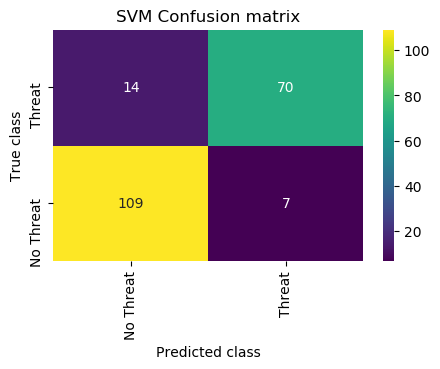

In [11]:
#train SVM algorithm and evaluate its performance
if os.path.exists("model/svm.txt"):
    with open('model/svm.txt', 'rb') as file:
        svm_cls = pickle.load(file)
    file.close()
else:
    svm_cls = svm.SVC()#create SVM object
    svm_cls.fit(X_train, y_train)#train on training data
    with open('model/svm.txt', 'wb') as file:
        pickle.dump(svm_cls, file)
    file.close()
predict = svm_cls.predict(X_test)#perform prediction on test data
#call metric function to calculate accuracy and other metrics
calculateMetrics("SVM", predict, y_test)


              precision    recall  f1-score   support

   No Threat       0.93      0.93      0.93       116
      Threat       0.90      0.90      0.90        84

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200

Decision Tree Accuracy  : 92.0
Decision Tree Precision   : 91.78981937602627
Decision Tree Recall      : 91.78981937602627
Decision Tree FMeasure    : 91.78981937602627


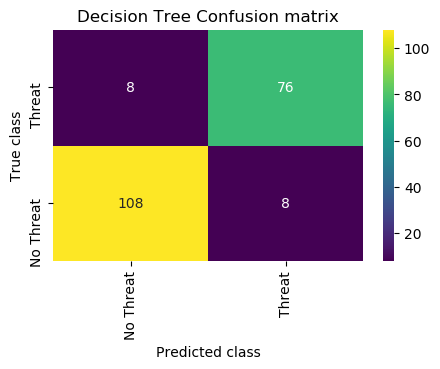

In [12]:
#train decision tree algorithm
if os.path.exists("model/dt.txt"):
    with open('model/dt.txt', 'rb') as file:
        dt_cls = pickle.load(file)
    file.close()
else:
    dt_cls = DecisionTreeClassifier()#create Decision Tree object
    dt_cls.fit(X_train, y_train)#train on training data
    with open('model/dt.txt', 'wb') as file:
        pickle.dump(dt_cls, file)
    file.close()
predict = dt_cls.predict(X_test)#perform prediction on test data
#call metric function to calculate accuracy and other metrics
calculateMetrics("Decision Tree", predict, y_test)

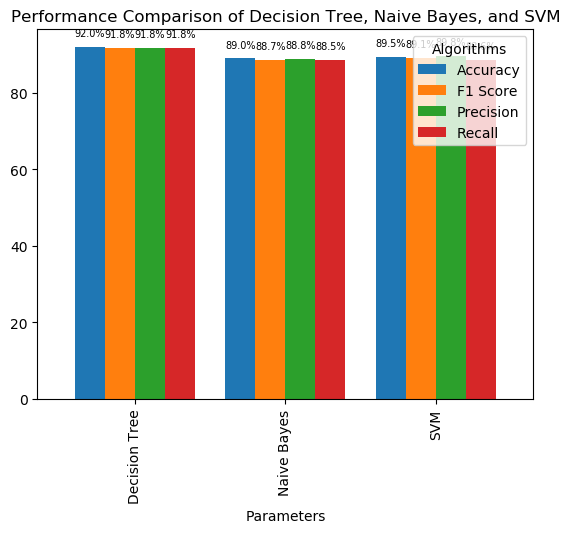

In [13]:
df = pd.DataFrame([
    ['Naive Bayes', 'Precision', precision[0]],
    ['Naive Bayes', 'Recall', recall[0]],
    ['Naive Bayes', 'F1 Score', fscore[0]],
    ['Naive Bayes', 'Accuracy', accuracy[0]],
    ['SVM', 'Precision', precision[1]],
    ['SVM', 'Recall', recall[1]],
    ['SVM', 'F1 Score', fscore[1]],
    ['SVM', 'Accuracy', accuracy[1]],
    ['Decision Tree', 'Precision', precision[2]],
    ['Decision Tree', 'Recall', recall[2]],
    ['Decision Tree', 'F1 Score', fscore[2]],
    ['Decision Tree', 'Accuracy', accuracy[2]],
], columns=['Parameters', 'Algorithms', 'Value'])

# Filtering out rows related to 'Extension Random Forest'
df = df[df['Algorithms'] != 'Extension Random Forest']

# Plotting the graph with increased bar width
ax = df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', width=0.8)
plt.title("Performance Comparison of Decision Tree, Naive Bayes, and SVM")

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=7)

plt.show()

In [14]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["Naive Bayes","SVM", "Decision Tree"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,Naive Bayes,88.817693,88.546798,88.672639,89.0
1,SVM,89.763489,88.649425,89.084955,89.5
2,Decision Tree,91.789819,91.789819,91.789819,92.0


In [15]:
from nrclex import NRCLex
text="We applaud the politician for championing education reform in our community. Their dedication to improving our schools is truly commendable."

emotion=NRCLex(text)
print(emotion.top_emotions)

[('positive', 0.7142857142857143)]


In [16]:
from nrclex import NRCLex

text="The politician scandalous behavior has once again disappointed the public. It disheartening to see our leaders involved in such corruption."
emotion=NRCLex(text)
print(emotion.top_emotions)

[('negative', 0.3333333333333333)]


In [17]:
from nrclex import NRCLex
text="The politician is very corrupted but he does many good things"
emotion=NRCLex(text)
print(emotion.top_emotions)

[('trust', 0.2), ('surprise', 0.2), ('positive', 0.2), ('joy', 0.2), ('anticipation', 0.2)]


In [18]:
'''line_index = 0  # Change this to the index of the line you want to print
print("TF-IDF vector for line", line_index, ":", X[line_index])'''

'line_index = 0  # Change this to the index of the line you want to print\nprint("TF-IDF vector for line", line_index, ":", X[line_index])'

In [19]:
'''import pickle

# Open the .pckl file for reading in binary mode
with open("dt.txt", "rb") as file:
    # Load the serialized data and reconstruct the Python object
    obj = pickle.load(file)
print(obj)'''

'import pickle\n\n# Open the .pckl file for reading in binary mode\nwith open("dt.txt", "rb") as file:\n    # Load the serialized data and reconstruct the Python object\n    obj = pickle.load(file)\nprint(obj)'

In [20]:
'''import numpy as np
data = np.load('dt.txt')
print(data)'''

"import numpy as np\ndata = np.load('dt.txt')\nprint(data)"

In [21]:
'''print(vectorizer.get_feature_names())'''

'print(vectorizer.get_feature_names())'